In [2]:
#Riccardo Seppi - MPE - HEG (2019) - 25 October
#This code reads halo masses from DM simulations (GLAM)
#builds HMF and fits them to models with fixed cosmological parameters

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dynesty
import glob
from dynesty import plotting as dyplot

catalog='/data26s/comparat/simulations/GLAM/1Gpc2000x4000/CATALOGS/CatshortV.0130.0001.DAT'

#read here the cosmological parameters
a = np.loadtxt(catalog, usecols=[2], skiprows=1, max_rows=1, dtype=float)
z = 1/a - 1
print('z = ',z)
Omega0 = np.loadtxt(catalog, usecols=[1], skiprows=3, max_rows=1, dtype=float)
print('Omega0 = ', Omega0)
#Omega0DE = np.loadtxt(catalog, usecols=[3], skiprows=3, max_rows=1, dtype=float)
#print('Omega0DE = ', Omega0DE)
hubble = np.loadtxt(catalog, usecols=[6], skiprows=3, max_rows=1, dtype=float)
print('h = ', hubble)
#params = {'flat': False, 'H0': hubble*100, 'Om0': Omega0, 'Ode0': Omega0DE}
params = {'flat': True, 'H0': hubble*100, 'Om0': Omega0, 'Ob0': 0.049, 'sigma8': 0.828, 'ns': 0.96}

#read masses of the halos identified by Rockstar
print('reading masses from the catalog...')
masses = []
ncat=0
for catalog in glob.glob('/data26s/comparat/simulations/GLAM/1Gpc2000x4000/CATALOGS/CatshortV.0130.0001.DAT'):
	ncat = ncat+1
	print('reading masses from catalog ', catalog)
	mass = np.loadtxt(catalog, usecols=[7], skiprows=8, dtype=float)
	masses = np.append(masses,mass)	

masses.sort()
#masses = masses/hubble
print('Lowest mass: %.3g' %np.min(masses))
print('Maximun mass: %.3g' %np.max(masses))

z =  0.09680391339636296
Omega0 =  0.3071
h =  0.678
reading masses from the catalog...
reading masses from catalog  /data26s/comparat/simulations/GLAM/1Gpc2000x4000/CATALOGS/CatshortV.0130.0001.DAT
Lowest mass: 5.54e+11
Maximun mass: 3.69e+15


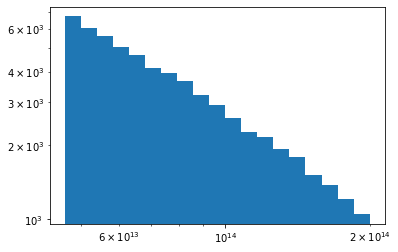

[0.07671244 0.07671244 0.07671244 0.07671244 0.07671244 0.07671244
 0.07671244 0.07671244 0.07671244 0.07671244 0.07671244 0.07671244
 0.07671244 0.07671244 0.07671244 0.07671244 0.07671244 0.07671244
 0.07671244]
number of halos in each bin:  [6722 6039 5582 5060 4665 4155 3935 3655 3218 2932 2586 2269 2163 1938
 1785 1515 1377 1204 1047]
total number of halos used:  61847
total number of halos in the simulation:  2906406
[4.82678434e+13 5.21163131e+13 5.62716272e+13 6.07582509e+13
 6.56026001e+13 7.08331967e+13 7.64808369e+13 8.25787721e+13
 8.91629052e+13 9.62720013e+13 1.03947917e+14 1.12235845e+14
 1.21184582e+14 1.30846816e+14 1.41279434e+14 1.52543862e+14
 1.64706420e+14 1.77838717e+14 1.92018072e+14]


In [3]:
#create mass bins and count halos in different bins
nbins=20
mass_number, mass_bins = np.histogram(masses,bins=np.logspace(13.667,14.3,nbins))
plt.hist(masses,mass_bins)
plt.loglog()
plt.show()
    
diff = np.diff(np.log(mass_bins))
print(diff)
diff=diff[0]


#print('mass_number length = ', len(mass_number), 'mass_bins length = ', len(mass_bins))
print('number of halos in each bin: ',mass_number)   
print('total number of halos used: ',np.sum(mass_number))
print('total number of halos in the simulation: ', len(masses))
             
#compute Poisson error in each bin
#the simulation is a cube of 1 Gpc/h...
#divide the number by 10^9 to get the number per (Mpc/h)^3
counts_error = np.sqrt(mass_number)/diff/10**9/ncat#*np.log10(np.e)
mass_number = mass_number/(ncat*10**9)/diff#*np.log10(np.e)

   
#now I can build the mass function
#plot each data in the middle of its respective mass bin
mass_bins_pl = np.zeros(len(mass_number))
for i in range(len(mass_number)):
	mass_bins_pl[i] = np.exp((np.log(mass_bins[i+1]) + np.log(mass_bins[i]))/2)
print(mass_bins_pl)

#Now I want to fit it
#consider the model (comparat17, tinker08...)
#NB: z will have to be the same of the simulation analyzed!!!
from colossus.lss import mass_function as mf
from colossus.cosmology import cosmology
from colossus.lss import peaks
#cosmology.setCosmology('planck18')
cosmology.addCosmology('myCosmo', params) #params was defined at line 27
cosmo=cosmology.setCosmology('myCosmo')
#print(cosmo.rho_m(0.0))

#fitting with Bhattacharya 2011
A0 = 0.333
a0 = 0.788
p0 = 0.807
q0 = 1.795
def mass_function_rseppi(Mass,A0,a0,p0,q0):
	cosmo=cosmology.getCurrent()	
	delta_c = peaks.collapseOverdensity(z=z)
	R = peaks.lagrangianR(Mass)
	sigma = cosmo.sigma(R=R,z=z)
	nu = delta_c / sigma
	nu2 = nu**2
	zp1 = 1.0+z
	A = A0 * zp1**-0.11
	a = a0 * zp1**-0.01
	p = p0
	q = q0
	f = A * np.sqrt(2 / np.pi) * np.exp(-a * nu2 * 0.5) * (1.0 + (a*nu2)**-p) * (nu * np.sqrt(a))**q

	d_ln_sigma_d_ln_R = cosmo.sigma(R, z, derivative = True)
	rho_Mpc = cosmo.rho_m(0.0) * 1E9
	mass_func_model = -1/3*f*rho_Mpc/Mass*d_ln_sigma_d_ln_R
	return mass_func_model


mass_func_model = mass_function_rseppi(mass_bins_pl,A0,a0,p0,q0)
#print('model values = ', mass_func_model)
#mass_func_model=mf.massFunction(mass_bins_pl,z=z,mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')

In [4]:
# Define the parameters dimensionality: 4 for comparat17
ndim = 4
import lmfit
from tqdm import tqdm
import emcee
p=lmfit.Parameters()
p.add_many(('A0', 0.333, True, 0.0,0.35),('a0', 0.788, True,0.75,1.2),('p0', 0.807, True,0.0,0.9),('q0', 1.795, True,1.5,2.5))

def log_prior(p):
    #v=p.valuesdict()
    mu = [0.333, 0.788, 0.807, 1.795]
    sigma = [0.15, 0.4, 0.45, 1.0]	
    #if 0.2 < v['A0'] < 0.5 and 0.6 < v['a0'] < 1.5 and 0.0 < v['p0'] < 2.0 and 1.5 < v['q0'] < 2.5:
    if 0.2 < p[0] < 0.5 and 0.6 < p[1] < 1.5 and 0.0 < p[2] < 2.0 and 1.5 < p[3] < 2.5:
        return np.sum((1/np.sqrt(2*np.pi*sigma*sigma))-0.5*((mu-p)/sigma)**2)
    return -np.inf

#define residual function
def residual(p):
    v=p.valuesdict() 	
    res = (mass_number - mass_function_rseppi(mass_bins_pl,v['A0'],v['a0'],v['p0'],v['q0']))/counts_error
    return res	
print('residuals =',residual(p))

mi = lmfit.minimize(residual, p, method='leastsq')
# print report on the leastsq fit 
lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)
print(mi.params)


#now I want to use MCMC method
def loglike(p):
	resid = residual(p)
	resid = resid**2
	resid = resid + np.log(2*np.pi*counts_error**2)
	logL = -0.5*np.sum(resid)
	if(np.isnan(logL)):
		logL=-np.inf
	return logL

def logPoisson(p):
	v=p.valuesdict() 	
	logL = - np.sum(mass_function_rseppi(mass_bins_pl,v['A0'],v['a0'],v['p0'],v['q0'])) + np.sum(mass_number*np.log(mass_function_rseppi(mass_bins_pl,v['A0'],v['a0'],v['p0'],v['q0'])))
	if(np.isnan(logL)):
		logL=-np.inf
	return logL

def logProb(p):
	lp = log_prior(p)
	if not np.isfinte(lp):
		return -np.inf
	return lp + loglike

# build a general minimizer for curve fitting and optimization.
mini = lmfit.Minimizer(logProb, mi.params, nan_policy='propagate')
#mini = lmfit.Minimizer(logPoisson, mi.params, nan_policy='propagate')
# sampling of the posterion distribution
res = mini.emcee(burn=300, steps=2000, thin=10,params=mi.params)

# show corner plot (confidence limits, parameter distributions, correlations)
print('parameters plot')
import corner
figure=corner.corner(res.flatchain, labels=res.var_names, 
                     truths=list(res.params.valuesdict().values()),
                     show_titles=True, title_kwargs={"fontsize": 12})
#plt.show()
print("median of posterior probability distribution")
print('------------------------------------------')
lmfit.report_fit(res.params)

plt.figure()
plt.errorbar(mass_bins_pl,mass_number,yerr=counts_error, fmt='.', label='data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'M [$M_{\odot}/h]$', fontsize=18)
plt.ylabel(r'dn/dlnM $[(Mpc/h)^{-3}]$',fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.plot(mass_bins_pl, mass_func_model, label='model_rseppi')
mf_test = mf.massFunction(mass_bins_pl,z=z,mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
plt.plot(mass_bins_pl, mf_test, label='Bhattacharya11')
mf_test_tinker = mf.massFunction(mass_bins_pl,z=z,mdef = '200m', model = 'tinker08', q_out = 'dndlnM')
plt.plot(mass_bins_pl, mf_test_tinker, label='tinker08')
plt.plot(mass_bins_pl,mass_function_rseppi(mass_bins_pl,mi.params['A0'],mi.params['a0'],mi.params['p0'],mi.params['q0']), label='fit')
plt.legend()
plt.show()

# Define our uniform prior via the prior transform.
def ptform(u):
    return 1.0*u

'''
#dynamic nested sampling
dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim)
dsampler.run_nested()
dresults = dsampler.results
'''

#plot the results
# initialize figure
#fig, axes = plt.subplots(4, 4)
#axes = axes.reshape((3, 7))  # reshape axes

'''
# plot results
fg, ax = dyplot.cornerplot(dresults, color='blue', truths=np.zeros(ndim),
                           truth_color='black', show_titles=True,
                           max_n_ticks=3, quantiles=None,
                           fig=(fig, axes[:, :4]))
plt.plot()
'''

residuals = [-10.61829879 -12.20802305 -11.28421456 -11.83659175 -10.99354981
 -12.55613644  -9.72793172  -8.29347104 -10.1874871   -9.78708277
 -11.14610305 -12.55171927  -9.45404619  -9.55884919  -8.25867125
 -10.57989896  -9.68206047 -10.29640236 -10.93249547]
[[Variables]]
    A0:  0.26175579 +/- 0.48471588 (185.18%) (init = 0.333)
    a0:  1.12210750 +/- 1.83205870 (163.27%) (init = 0.788)
    p0:  0.89999986 +/- 15.0132635 (1668.14%) (init = 0.807)
    q0:  2.43832609 +/- 6.38682903 (261.93%) (init = 1.795)
[[Correlations]] (unreported correlations are < 0.500)
    C(a0, q0) =  1.000
    C(p0, q0) =  0.995
    C(a0, p0) =  0.994
    C(A0, p0) =  0.991
    C(A0, q0) =  0.973
    C(A0, a0) =  0.970
Parameters([('A0', <Parameter 'A0', value=0.2617557857225469 +/- 0.485, bounds=[0.0:0.35]>), ('a0', <Parameter 'a0', value=1.122107496793825 +/- 1.83, bounds=[0.75:1.2]>), ('p0', <Parameter 'p0', value=0.8999998640588952 +/- 15, bounds=[0.0:0.9]>), ('q0', <Parameter 'q0', value=2.4383260

KeyError: 0